In [0]:
from google.colab import drive
drive.mount("./gdrive")

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = '/content/Assignment 5 Dataset'

In [0]:
#!unzip "/content/gdrive/My Drive/Assignment 5 Dataset.zip"

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data=datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)  ##Train-Transform to the Validation data also
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,num_workers=16)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True,num_workers=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,num_workers=16)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
'''
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)
'''

"\ndef imshow(inp, title=None):\n    inp = inp.numpy().transpose((1, 2, 0))\n    plt.axis('off')\n    plt.imshow(inp)\n    if title is not None:\n        plt.title(title)\n    plt.pause(0.001)\n\ndef show_databatch(inputs, classes):\n    out = torchvision.utils.make_grid(inputs)\n    imshow(out, title=[class_names[x] for x in classes])\n\n# Get a batch of training data\ninputs, classes = next(iter(trainloader))\nshow_databatch(inputs, classes)\n"

In [0]:
vgg16 = models.vgg16(pretrained=True)

In [0]:
print(vgg16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [0]:
#for param in vgg16.features[0:-3].parameters(): for Only one Conv Layer i.e. Last Layer, Uncomment this loop
'''
for param in vgg16.features[0:-13].parameters():
  param.requires_grad = False
'''

'\nfor param in vgg16.features[0:-13].parameters():\n  param.requires_grad = False\n'

In [0]:
for  param in vgg16.features.parameters():
  print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
vgg16.classifier.parameters
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] #Remove Last Layer

#features.extend([nn.Linear(num_features, 550)])
features.extend([nn.Linear(num_features, len(class_names))]) #Last output is 2. 
vgg16.classifier = nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
def validate(mdl,device):
  correct = 0
  total = 0
  los=0
  with torch.no_grad():
      for data in validationloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = mdl(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          los+=  loss.item()
  
  print('Accuracy of the network on the Validation images: %d %%' % (100 * correct / total))
  print('Loss of the network on the Validation images:',los)
  return los,correct / total


In [0]:
def confusion_matrix(y_pred,y_true):
  from sklearn.metrics import confusion_matrix
  tn, fp, fn, tp=confusion_matrix(y_true,y_pred).ravel()
  return tn, fp, fn, tp


In [0]:
def test(mdl,device):
  correct = 0
  total = 0
  tst_loss_vect=[]
  tst_accu_vect=[]
  los=0
  with torch.no_grad():
      for data in testloader:
          correc=0
          ttl=0
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = mdl(images)
          _, predicted = torch.max(outputs.data, 1)
          ttl= labels.size(0)
          total+=ttl
          correc= (predicted == labels).sum().item()
          correct+=correc
          loss = criterion(outputs, labels)
          tst_loss_vect.append(loss.item())
          tst_accu_vect.append(correc/ttl)

  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  return tst_loss_vect,tst_accu_vect

In [0]:
def train_validate_test(mdl):

    from tqdm import tqdm

    #if you have gpu then you need to convert the network and data to cuda
    #the easiest way is to first check for device and then convert network and data to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mdl.to(device)

    mdl.train()
    tr_loss_vect=[]
    tr_accu_vect=[]
    val_loss_vect=[]
    val_accu_vect=[]

    for epoch in range(Epochs):  # loop over the dataset multiple times
        correct = 0
        running_loss = 0.0
        pbar = tqdm(enumerate(trainloader))
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
            # because PyTorch accumulates the gradients on subsequent backward passes. 
            # This is convenient while training RNNs. 
            # So, the default action is to accumulate the gradients on every loss.backward() call

            # forward + backward + optimize
            outputs = mdl(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            # print statistics
            running_loss += loss.item()
            
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss.data.item()))
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        print('Accuracy of the network on the training images: %d %%' % (100 * correct / len(labels)))
        if mdl==vgg16:
          torch.save(mdl.state_dict(),'/content/gdrive/My Drive/vg166_entire.pth')
        else:
          torch.save(mdl.state_dict(),'/content/gdrive/My Drive/res18_entire.pth')
        val_ls,val_ac=validate(mdl,device)
        val_loss_vect.append(val_ls)
        val_accu_vect.append(val_ac)
        tr_loss_vect.append(running_loss)
        tr_accu_vect.append(correct / len(labels))
    print('Finished Training')
    tst_loss_vect,tst_accu_vect=test(mdl,device)
    return tr_loss_vect,tr_accu_vect,val_loss_vect,val_accu_vect,tst_loss_vect,tst_accu_vect

In [17]:
tr_loss_vect,tr_accu_vect,val_loss_vect,val_accu_vect,tst_loss_vect,tst_accu_vect=train_validate_test(vgg16)

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.112771: : 375it [01:51,  3.35it/s]


Accuracy of the network on the training images: 96 %
Accuracy of the network on the Validation images: 89 %
Loss of the network on the Validation images: 12.904381155967712


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.322828: : 375it [01:52,  3.35it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 90 %
Loss of the network on the Validation images: 10.766844525933266


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.249585: : 375it [01:53,  3.32it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 89 %
Loss of the network on the Validation images: 11.488988675177097


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.180952: : 375it [01:52,  3.34it/s]


Accuracy of the network on the training images: 96 %
Accuracy of the network on the Validation images: 90 %
Loss of the network on the Validation images: 11.041363190859556


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.179207: : 375it [01:52,  3.32it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 9.872334815561771


Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.230367: : 375it [01:52,  3.32it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 10.190734416246414


Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.125957: : 375it [01:52,  3.34it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 10.535614721477032


Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.154328: : 375it [01:52,  3.34it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 9.804625406861305


Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.071015: : 375it [01:52,  3.32it/s]


Accuracy of the network on the training images: 100 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 10.055631540715694


Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.102696: : 375it [01:52,  3.34it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 10.252245243638754
Finished Training
Accuracy of the network on the test images: 97 %


###VGG16 Training,Validation and Testing Curves 

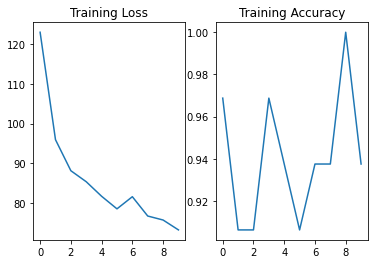

In [18]:
plt.subplot(1,2,1)
plt.title("Training Loss")
plt.plot(tr_loss_vect)
plt.subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(tr_accu_vect)
plt.show()

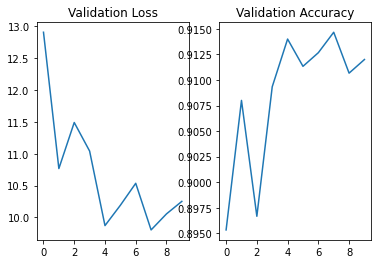

In [19]:
plt.subplot(1,2,1)
plt.plot(val_loss_vect)
plt.title("Validation Loss")
plt.subplot(1,2,2)
plt.plot(val_accu_vect)
plt.title("Validation Accuracy")
plt.show()

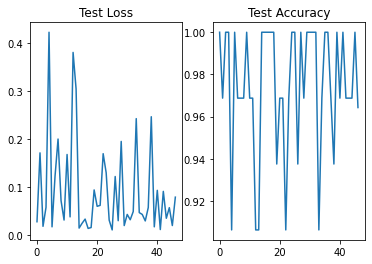

In [20]:
plt.subplot(1,2,1)
plt.plot(tst_loss_vect)
plt.title("Test Loss")
plt.subplot(1,2,2)
plt.plot(tst_accu_vect)
plt.title("Test Accuracy")
plt.show()

In [0]:
def confusion_matrix(y_pred,y_true):
  from sklearn.metrics import confusion_matrix
  tn, fp, fn, tp=confusion_matrix(y_true,y_pred).ravel()
  return tn, fp, fn, tp

In [0]:
def get_confusion_matrix(loader,mdl):
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tn1=0
    tp1=0
    fp1=0
    fn1=0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = mdl(images)
            _, predicted = torch.max(outputs.data, 1)
            tn, fp, fn, tp=confusion_matrix(labels.cpu(),predicted.cpu())
            tn1+=tn
            tp1+=tp
            fp1+=fp
            fn1+=fn
    print("The confusion matrix entries are as follows with gold labels")
    print("Tp =",tp1)
    print("Tn =",tn1)
    print("Fp =",fp1)
    print("Fn =",fn1)
    print("Accuracy = ", (tp1+tn1)/(tp1+tn1+fp1+fn1))
    print("Precision =", tp1/(tp1+fp1))
    pre=tp1/(tp1+fp1)
    recl=tp1/(tp1+fn1)
    print("Recall =",tp1/(tp1+fn1))
    print("F1 Measure",(2*pre*recl)/(pre+recl))
    return

###VGG16 Confusion Matrix Values

In [23]:
print("Confusion Matrix for Training Dataset")
get_confusion_matrix(trainloader,vgg16)
print("Confusion Matrix for Testing Dataset")
get_confusion_matrix(testloader,vgg16)
print("Confusion Matrix for Validation Dataset")
get_confusion_matrix(validationloader,vgg16)

Confusion Matrix for Training Dataset
The confusion matrix entries are as follows with gold labels
Tp = 6825
Tn = 4304
Fp = 256
Fn = 615
Accuracy =  0.9274166666666667
Precision = 0.9638469142776444
Recall = 0.9173387096774194
F1 Measure 0.9400179051029542
Confusion Matrix for Testing Dataset
The confusion matrix entries are as follows with gold labels
Tp = 878
Tn = 582
Fp = 7
Fn = 33
Accuracy =  0.9733333333333334
Precision = 0.992090395480226
Recall = 0.9637760702524698
F1 Measure 0.9777282850779511
Confusion Matrix for Validation Dataset
The confusion matrix entries are as follows with gold labels
Tp = 853
Tn = 520
Fp = 32
Fn = 95
Accuracy =  0.9153333333333333
Precision = 0.9638418079096045
Recall = 0.8997890295358649
F1 Measure 0.9307146753955264


### Resnet 18 Code will start from here

In [24]:
res18 = models.resnet18(pretrained=True)

'''for param in res18.parameters():   ### Freezing All layers
    param.requires_grad = False
'''

num_features=res18.fc.in_features

features = list(res18.fc.children())[:-1]

features.extend([nn.Linear(num_features, len(class_names))])
res18.fc=nn.Sequential(*features)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [25]:
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
'''for param in res18.layer4.parameters():   #Layer 4,ConvS ARE unfreezed
  param.requires_grad=True
for param in res18.layer3.parameters():   #Layer 3, ConvS ARE unfreezed
  param.requires_grad=True
'''


'for param in res18.layer4.parameters():   #Layer 4,ConvS ARE unfreezed\n  param.requires_grad=True\nfor param in res18.layer3.parameters():   #Layer 3, ConvS ARE unfreezed\n  param.requires_grad=True\n'

In [27]:
for param in res18.parameters():
  print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

In [29]:
tr_loss_vect,tr_accu_vect,val_loss_vect,val_accu_vect,tst_loss_vect,tst_accu_vect=train_validate_test(res18)

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.348800: : 375it [01:38,  3.83it/s]


Accuracy of the network on the training images: 81 %
Accuracy of the network on the Validation images: 87 %
Loss of the network on the Validation images: 14.959179401397705


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.204380: : 375it [01:37,  3.83it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 89 %
Loss of the network on the Validation images: 12.672660198062658


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.208020: : 375it [01:36,  3.88it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 90 %
Loss of the network on the Validation images: 11.357246652245522


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.280914: : 375it [01:36,  3.88it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 89 %
Loss of the network on the Validation images: 13.299190003424883


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.197528: : 375it [01:36,  3.87it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 90 %
Loss of the network on the Validation images: 11.17546059563756


Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.170313: : 375it [01:37,  3.86it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 90 %
Loss of the network on the Validation images: 10.889871574938297


Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.220365: : 375it [01:38,  3.82it/s]


Accuracy of the network on the training images: 87 %
Accuracy of the network on the Validation images: 89 %
Loss of the network on the Validation images: 11.57038363814354


Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.142256: : 375it [01:40,  3.72it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 90 %
Loss of the network on the Validation images: 10.715760622173548


Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.202406: : 375it [01:37,  3.86it/s]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 89 %
Loss of the network on the Validation images: 12.073992617428303


Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.178284: : 375it [01:37,  3.86it/s]


Accuracy of the network on the training images: 93 %
Accuracy of the network on the Validation images: 91 %
Loss of the network on the Validation images: 10.506027175113559
Finished Training
Accuracy of the network on the test images: 96 %


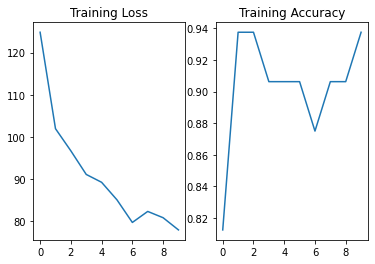

In [30]:
plt.subplot(1,2,1)
plt.title("Training Loss")
plt.plot(tr_loss_vect)
plt.subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(tr_accu_vect)
plt.show()

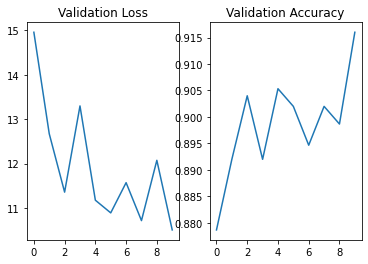

In [31]:
plt.subplot(1,2,1)
plt.plot(val_loss_vect)
plt.title("Validation Loss")
plt.subplot(1,2,2)
plt.plot(val_accu_vect)
plt.title("Validation Accuracy")
plt.show()

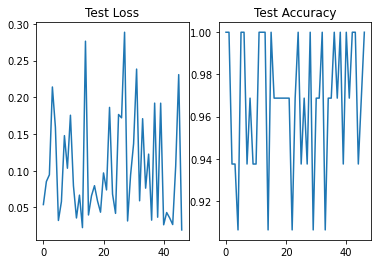

In [32]:
plt.subplot(1,2,1)
plt.plot(tst_loss_vect)
plt.title("Test Loss")
plt.subplot(1,2,2)
plt.plot(tst_accu_vect)
plt.title("Test Accuracy")
plt.show()

In [33]:
print("Confusion Matrix for Training Dataset")
get_confusion_matrix(trainloader,res18)
print("Confusion Matrix for Testing Dataset")
get_confusion_matrix(testloader,res18)
print("Confusion Matrix for Validation Dataset")
get_confusion_matrix(validationloader,res18)

Confusion Matrix for Training Dataset
The confusion matrix entries are as follows with gold labels
Tp = 6634
Tn = 4429
Fp = 447
Fn = 490
Accuracy =  0.9219166666666667
Precision = 0.9368733229769807
Recall = 0.9312184166198765
F1 Measure 0.9340373108060541
Confusion Matrix for Testing Dataset
The confusion matrix entries are as follows with gold labels
Tp = 865
Tn = 585
Fp = 20
Fn = 30
Accuracy =  0.9666666666666667
Precision = 0.9774011299435028
Recall = 0.9664804469273743
F1 Measure 0.9719101123595506
Confusion Matrix for Validation Dataset
The confusion matrix entries are as follows with gold labels
Tp = 805
Tn = 557
Fp = 80
Fn = 58
Accuracy =  0.908
Precision = 0.9096045197740112
Recall = 0.93279258400927
F1 Measure 0.9210526315789473
